In [1]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sccoda.util import data_visualization as viz


2025-05-24 23:28:51.303945: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 23:28:51.343993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-24 23:28:51.344025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-24 23:28:51.345123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-24 23:28:51.351603: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 23:28:51.352254: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import os
out_folder = './output'
os.makedirs(out_folder, exist_ok=True)

In [3]:
# the following are needed to ensure that text in plt images opens as text box rather than glyphs in adobe
plt.rcParams['pdf.fonttype'] = 42  
plt.rcParams['ps.fonttype'] = 42   


In [4]:
!pwd

/data/projects/zeba/MY_PROJECTS/240130_Xenium_ANCA_SLE_GBM/xenium-cgn-zeba-may25/xenium-cgn/notebooks/12_CellTypeProportions_BoxPlots


## AnnData Object with everything
Shared by Robin on 31 Oct Slack with me:
/data/projects/robin/segmentation/xenium_outs/adata_complete_reduced_withTransformedMC.h5ad
This is also the object that I have used for the Cellchat Analysis

In [5]:
#adata = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/adata_complete_reduced_withTransformedMC.h5ad")
adata = sc.read_h5ad('/data/projects/zeba/MY_PROJECTS/240130_Xenium_ANCA_SLE_GBM/xenium-cgn/notebooks_zs/02_PeriglomDefinition_Sample26updated/output_dataobjects/adata_complete_reduced_withTransformedMC_X26updated.h5ad')
adata

AnnData object with n_obs × n_vars = 3218210 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'label', 'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no', 'glom_ID', 'polygon_flags', 'is_in_polygon', 'is_in_glom', 'is_in_periglom', 'Slide_num'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_l1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'

In [6]:
rename_dict = {
    "Transformed mesangial": "Fibrotic MC",
    "mesangial cell": "MC",
}


adata.obs["celltype_l1"] = adata.obs["celltype_l1"].replace(rename_dict)

### Subset Cells in Tubulointerstitial Regions

In [7]:
adata=adata[adata.obs['is_in_polygon']==False]
adata

View of AnnData object with n_obs × n_vars = 2612553 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'label', 'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no', 'glom_ID', 'polygon_flags', 'is_in_polygon', 'is_in_glom', 'is_in_periglom', 'Slide_num'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_l1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'

In [8]:
df_sample_celltypes = adata.obs[["Patient_Sample_ID","celltype_l1"]]
df_sample_celltypes

,Patient_Sample_ID,celltype_l1
cell_CR4f0dee9aa-1,X8_SLE,EC
cell_CR4f0dee9aa-2,X8_SLE,EC
cell_CR4f0dee9aa-3,X8_SLE,MAC
cell_CR4f0dee9aa-4,X8_SLE,EC
cell_CR4f0dee9aa-5,X8_SLE,PEC
...,...,...
cell_CR4113b3b6d-453300,X62_SLE,CNT
cell_CR4113b3b6d-453330,X62_SLE,EC
cell_CR4113b3b6d-453344,X58_ANCA,DTL
cell_CR4113b3b6d-453638,X57_Cntrl,EC


In [9]:
df_sampleXcelltypes = df_sample_celltypes.groupby(["Patient_Sample_ID","celltype_l1"]).size().reset_index(name='counts')
df_sampleXcelltypes

,Patient_Sample_ID,celltype_l1,counts
0,X1_Cntrl,podocyte,276
1,X1_Cntrl,PEC,773
2,X1_Cntrl,MC,227
3,X1_Cntrl,PapE,190
4,X1_Cntrl,VSM/P,4468
...,...,...,...
1822,X63_ANCA,MAST,194
1823,X63_ANCA,cDC,463
1824,X63_ANCA,pDC,68
1825,X63_ANCA,cycMNP,1243


In [10]:
df_sampleXcelltypes = df_sampleXcelltypes.pivot(index= "Patient_Sample_ID", columns="celltype_l1", values="counts").fillna(0)
df_sampleXcelltypes = df_sampleXcelltypes.astype(int)

In [11]:
df_sampleXcelltypes["Patient_Sample_ID_col"]=df_sampleXcelltypes.index

In [12]:
df_sampleXcelltypes

celltype_l1,podocyte,PEC,MC,PapE,VSM/P,EC,PT,ATL,CNT,DCT,...,N,MAC,MDC,Mono,MAST,cDC,pDC,cycMNP,cycNKC/T,Patient_Sample_ID_col
Patient_Sample_ID,,,,,,,,,,,,,,,,,,,,,
X1_Cntrl,276,773,227,190,4468,7956,22880,96,3770,5006,...,112,2737,1017,422,216,303,93,131,15,X1_Cntrl
X2_Cntrl,515,517,150,240,1251,2992,5556,104,1138,1080,...,166,910,464,146,183,152,37,164,12,X2_Cntrl
X3_ANCA,215,672,134,377,1522,5353,8507,636,1041,724,...,396,4190,2175,672,166,272,67,411,63,X3_ANCA
X4_ANCA,172,301,110,175,811,2543,7205,56,804,495,...,206,1563,1463,467,284,153,115,143,28,X4_ANCA
X5_GBM,211,571,46,203,325,1457,2269,94,494,76,...,1877,8538,2535,2514,68,150,84,563,53,X5_GBM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X59_ANCA,299,604,203,680,1143,3797,1892,891,761,158,...,1537,7163,1708,700,558,259,50,1429,113,X59_ANCA
X60_ANCA,347,668,152,241,1344,4219,11094,76,978,952,...,359,2456,1582,551,268,292,117,281,52,X60_ANCA
X61_SLE,33,87,26,19,248,1610,4620,6,456,315,...,137,1509,294,284,21,101,16,184,41,X61_SLE


## Convert the df to a AnnData object

In [13]:
data_Xen = dat.from_pandas(df_sampleXcelltypes, covariate_columns=["Patient_Sample_ID_col"])

# Extract condition from mouse name and add it as an extra column to the covariates
#data_mouse.obs["Condition"] = data_mouse.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_Xen.X)
print(data_Xen.obs)
data_Xen

[[ 276  773  227 ...   93  131   15]
 [ 515  517  150 ...   37  164   12]
 [ 215  672  134 ...   67  411   63]
 ...
 [  33   87   26 ...   16  184   41]
 [ 322  505  272 ...   28  218   40]
 [ 713 1580  216 ...   68 1243  133]]
celltype_l1       Patient_Sample_ID_col
Patient_Sample_ID                      
X1_Cntrl                       X1_Cntrl
X2_Cntrl                       X2_Cntrl
X3_ANCA                         X3_ANCA
X4_ANCA                         X4_ANCA
X5_GBM                           X5_GBM
...                                 ...
X59_ANCA                       X59_ANCA
X60_ANCA                       X60_ANCA
X61_SLE                         X61_SLE
X62_SLE                         X62_SLE
X63_ANCA                       X63_ANCA

[63 rows x 1 columns]


AnnData object with n_obs × n_vars = 63 × 29
    obs: 'Patient_Sample_ID_col'

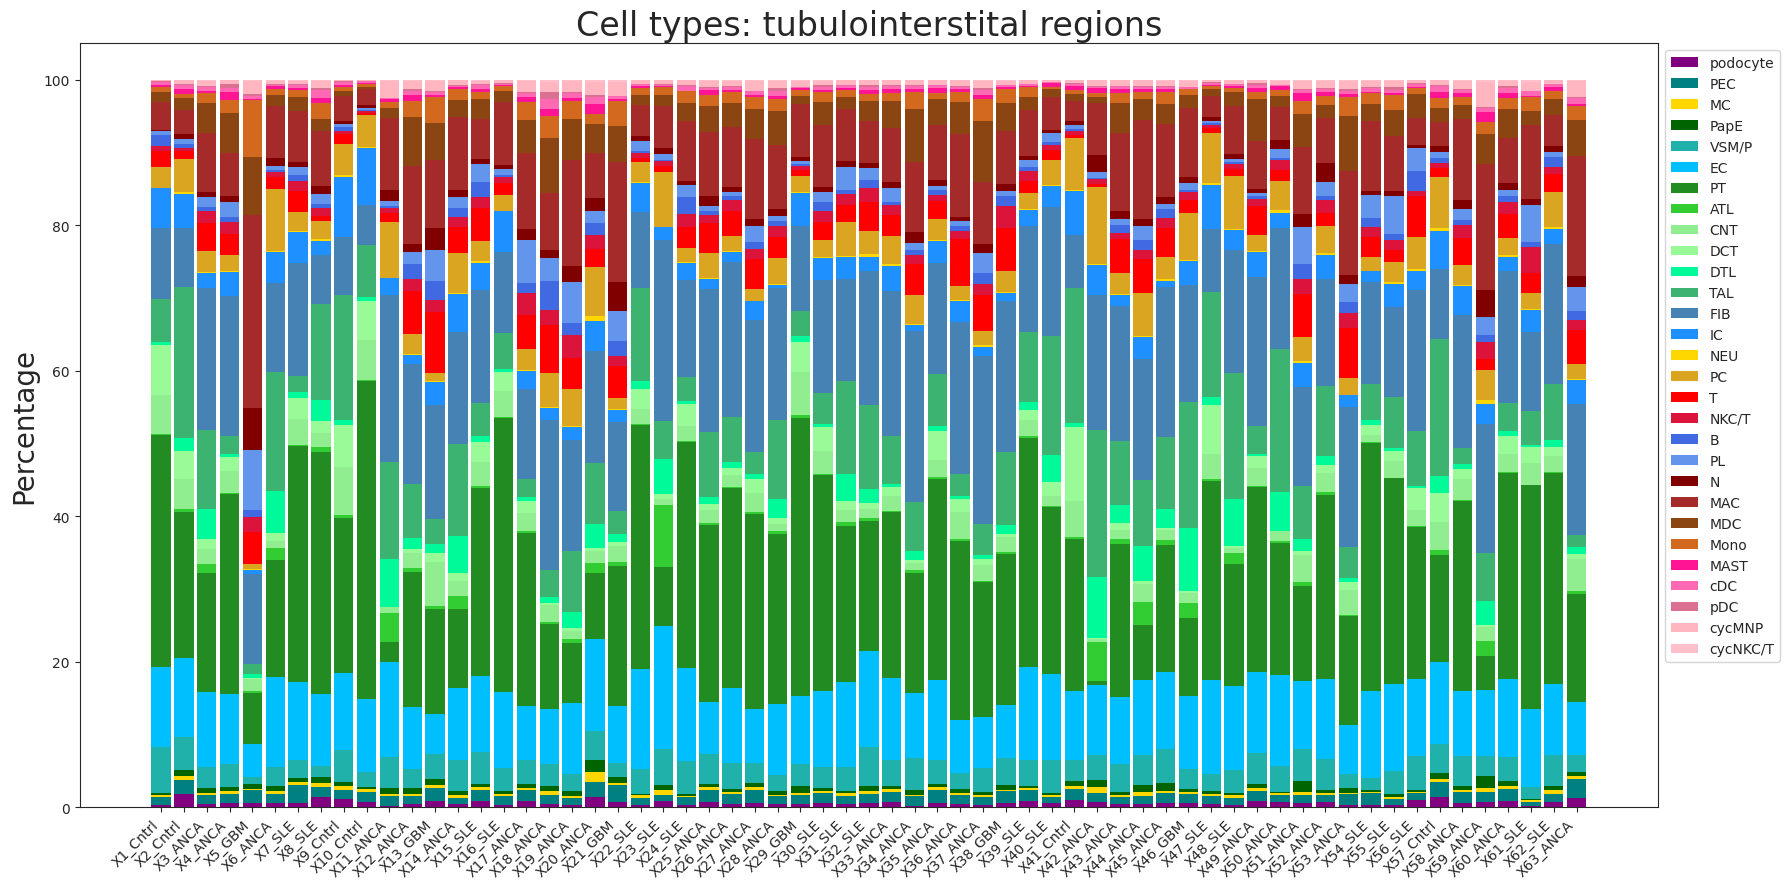

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sccoda.util import data_visualization as viz

# Extract the colors from adata
colors = adata.uns["celltype_l1_colors"]

# Convert the list of colors to a Matplotlib colormap
colormap = ListedColormap(colors)

plt.rcParams['figure.figsize'] = [18, 9]
viz.stacked_barplot(data=data_Xen, feature_name="Patient_Sample_ID_col", cmap=colormap)

# Customize fonts and plot
title_fontsize = 24
label_fontsize = 20
tick_fontsize = 10
legend_fontsize = 18

plt.title('Cell types: tubulointerstital regions', fontsize=title_fontsize)
#plt.xlabel("")  # Remove x-axis label
plt.ylabel('Percentage', fontsize=label_fontsize)
plt.xticks(rotation=45, fontsize=tick_fontsize, ha='right', va='top')
plt.yticks(fontsize=tick_fontsize)
#plt.legend(title='Condition', title_fontsize=legend_fontsize, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("./output/Barplot_CellType_Percentages_Tubulointerstital.png")
plt.savefig("./output/Barplot_CellType_Percentages_Tubulointerstital.pdf")
plt.show()

In [15]:
df_sampleXcelltypes["condition"]=df_sampleXcelltypes["Patient_Sample_ID_col"].str.split("_").str[1]

con_order=['Cntrl', 'SLE', 'ANCA', 'GBM']
df_sampleXcelltypes["condition"]=pd.Categorical(df_sampleXcelltypes["condition"], categories=con_order, ordered=True)

In [16]:
cell_type_columns = df_sampleXcelltypes.columns.difference(['Patient_Sample_ID_col', 'condition'])
df_sampleXcelltypes['Total_Cells'] = df_sampleXcelltypes[cell_type_columns].sum(axis=1)

# ## Calculate Percentages
for col in cell_type_columns:
    df_sampleXcelltypes[col] = (df_sampleXcelltypes[col] / df_sampleXcelltypes['Total_Cells'])*100


df_sampleXcelltypes_long = df_sampleXcelltypes.melt(id_vars=['Patient_Sample_ID_col', 'condition'], 
                  value_vars=cell_type_columns, 
                  var_name='Cell_Type', 
                  value_name='Percentage')

df_sampleXcelltypes_long

,Patient_Sample_ID_col,condition,Cell_Type,Percentage
0,X1_Cntrl,Cntrl,ATL,0.133807
1,X2_Cntrl,Cntrl,ATL,0.376430
2,X3_ANCA,ANCA,ATL,1.223289
3,X4_ANCA,ANCA,ATL,0.212831
4,X5_GBM,GBM,ATL,0.291935
...,...,...,...,...
1822,X59_ANCA,ANCA,podocyte,0.720256
1823,X60_ANCA,ANCA,podocyte,0.881807
1824,X61_SLE,SLE,podocyte,0.220088
1825,X62_SLE,SLE,podocyte,0.724377


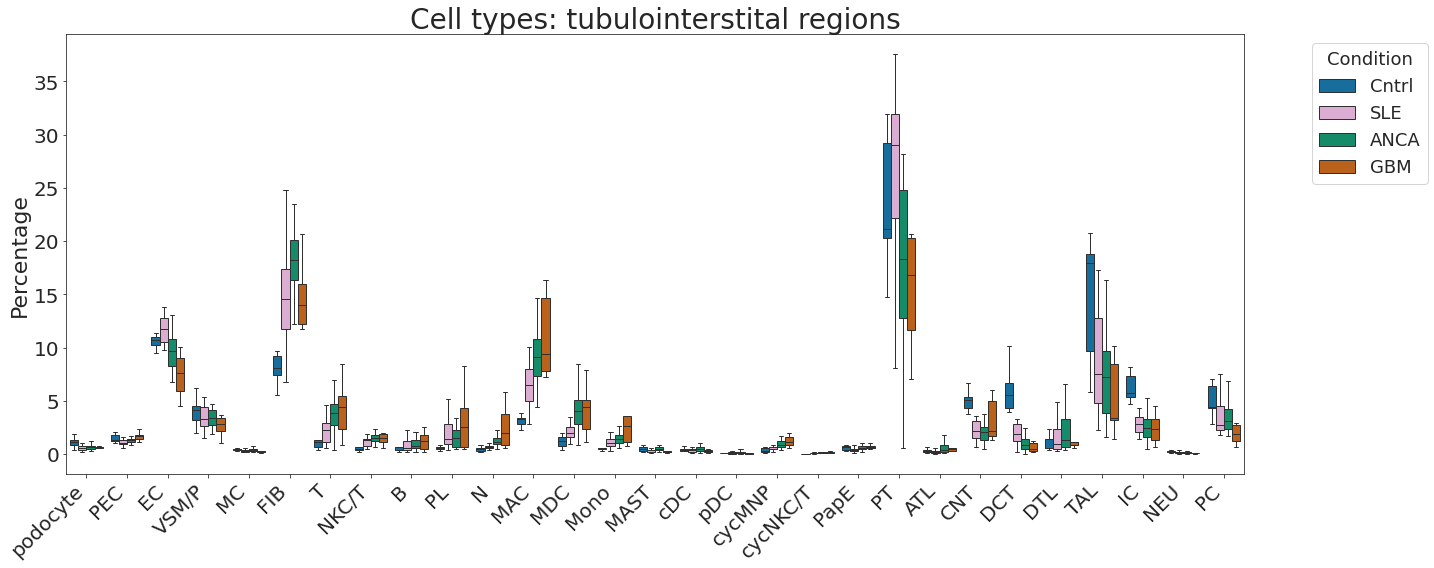

In [17]:

custom_palette = {
    'Cntrl': '#0173b2',  
    'SLE': '#E3A5D6FF',   
    'ANCA': '#029e73',   
    'GBM': '#d55e00'     
}



cell_type_order = [
    'podocyte', 'PEC', 'EC','VSM/P','MC','FIB',
    'T', 'NKC/T', 'B', 'PL', 'N', 'MAC', 'MDC', 'Mono', 'MAST', 'cDC', 'pDC', 'cycMNP', 'cycNKC/T', 
    'PapE', 'PT', 'ATL', 'CNT', 'DCT', 'DTL', 'TAL', 'IC', 'NEU', 'PC'
]


plt.figure(figsize=(20, 8))
sns.boxplot(
    data=df_sampleXcelltypes_long, 
    x='Cell_Type', 
    y='Percentage', 
    hue='condition', 
    palette=custom_palette, 
    order=cell_type_order,
    showfliers=False  
)


title_fontsize = 28
label_fontsize = 22
tick_fontsize = 20
legend_fontsize = 18

plt.title('Cell types: tubulointerstital regions', fontsize=title_fontsize)
plt.xlabel("") 
plt.ylabel('Percentage', fontsize=label_fontsize)
plt.xticks(rotation=45, fontsize=tick_fontsize, ha='right', va='top')
plt.yticks(fontsize=tick_fontsize)
plt.legend(title='Condition', title_fontsize=legend_fontsize, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("./output/Boxplot_CellType_Percentages_Tubulointerstital.png")
plt.savefig("./output/Boxplot_CellType_Percentages_Tubulointerstital.pdf")
plt.show()


In [18]:
df_sampleXcelltypes_long

,Patient_Sample_ID_col,condition,Cell_Type,Percentage
0,X1_Cntrl,Cntrl,ATL,0.133807
1,X2_Cntrl,Cntrl,ATL,0.376430
2,X3_ANCA,ANCA,ATL,1.223289
3,X4_ANCA,ANCA,ATL,0.212831
4,X5_GBM,GBM,ATL,0.291935
...,...,...,...,...
1822,X59_ANCA,ANCA,podocyte,0.720256
1823,X60_ANCA,ANCA,podocyte,0.881807
1824,X61_SLE,SLE,podocyte,0.220088
1825,X62_SLE,SLE,podocyte,0.724377


In [19]:
median_Percentage = df_sampleXcelltypes_long.groupby(['condition', 'Cell_Type'])['Percentage'].median().reset_index()

In [20]:
median_Percentage.to_csv('./output/median_Percentage_celltype_Tubulointerstital.csv')

In [21]:
filtered_df = median_Percentage[median_Percentage['Cell_Type'] == 'podocyte']
#filtered_df['perc']=filtered_df.Percentage*100
filtered_df

,condition,Cell_Type,Percentage
28,Cntrl,podocyte,1.100837
57,SLE,podocyte,0.596760
86,ANCA,podocyte,0.627519
115,GBM,podocyte,0.646872
